In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import seaborn as sns

from src.data.preprocess import extend_market_data

# Getting and preprocessing the data

In [2]:
SRW = yf.Ticker("ZW=F")
SRW_data = SRW.history(start ="2014-01-01").drop(['Dividends', 'Stock Splits'], axis=1)
SRW_data = extend_market_data(SRW_data)
SRW_data['Target'] = SRW_data['Log_Return'].shift(-1)
SRW_data.dropna(inplace=True)
SRW_data.head()

,Open,High,Low,Close,Volume,Year,Month,Day,Day_Of_Year,expiry,...,14D_ATR,Volume_Volatility_Ratio,14D_RSI,7D_MA,14D_MA,21D_MA,7D_EMA,14D_EMA,21D_EMA,Target
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-31,554.00,557.50,551.25,555.75,45491,2014,1,31,31,2014-03-14,...,9.696429,3.747362e+06,41.137124,560.785714,564.696429,574.226190,559.350382,565.575989,570.774376,0.014292
2014-02-03,555.00,564.25,554.00,563.75,45262,2014,2,3,34,2014-03-14,...,9.928571,3.581171e+06,43.769968,559.892857,564.000000,572.642857,560.450287,565.332524,570.135796,0.036146
2014-02-04,563.75,585.75,562.00,584.50,84912,2014,2,4,35,2014-03-14,...,10.964286,5.330416e+06,52.815013,562.642857,564.375000,571.630952,566.462715,567.888188,571.441633,0.005119
2014-02-05,585.00,588.75,579.00,587.50,76582,2014,2,5,36,2014-03-14,...,10.714286,5.176564e+06,61.651917,566.071429,565.785714,570.761905,571.722036,570.503096,572.901485,-0.011556
2014-02-06,587.00,592.75,579.50,580.75,68517,2014,2,6,37,2014-03-14,...,10.964286,4.531812e+06,54.624277,568.178571,566.357143,569.726190,573.979027,571.869350,573.614986,-0.005612


# Defining the feature columns and the train test split

In [3]:
feature_cols = ['Close', 'Volume', 'Day_Of_Year', 'Year', 'Month', 'Day' ,'DTE', '7D_Volatility', '14D_ATR', '7D_MA', '7D_EMA', '14D_RSI']
splitting_point = '2024-01-01'

scaler = StandardScaler()

X_test_pd = SRW_data[SRW_data.index >= splitting_point][feature_cols]
y_test = SRW_data[SRW_data.index >= splitting_point]['Target']
X_train_pd = SRW_data[SRW_data.index < splitting_point][feature_cols]
y_train = SRW_data[SRW_data.index < splitting_point]['Target']

X_train = scaler.fit_transform(X_train_pd)
X_test = scaler.transform(X_test_pd)

# Linear regression model with CV

Cross-validation R^2 scores on the training set: [-0.01120876 -0.34761026 -0.00568749 -0.15440042 -0.01030711]
Average R^2 score: -0.1058
The R^2 score on the testing set: -0.0140


<Axes: title={'center': 'The Linear Regression Model on the training set'}, xlabel='Date', ylabel='Target'>

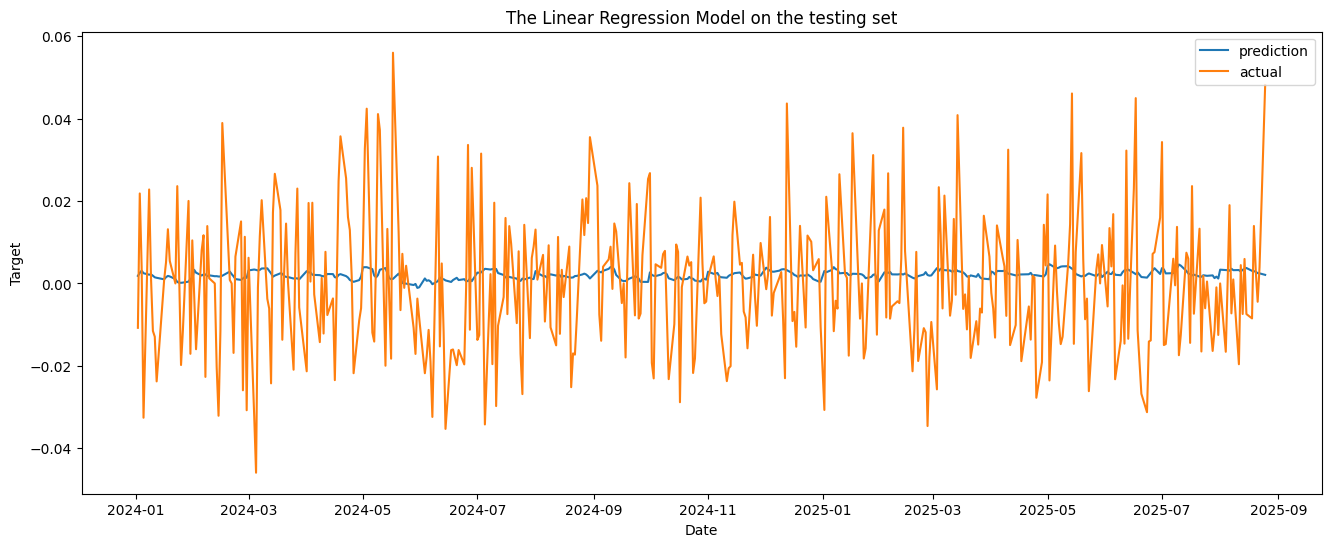

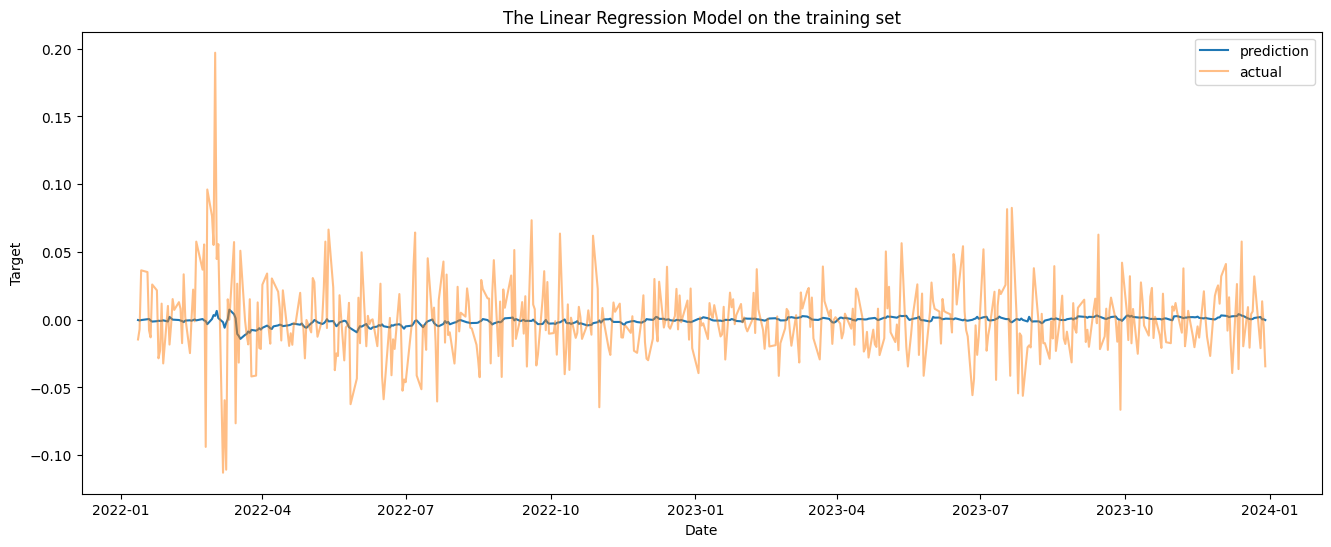

In [4]:
tscv = TimeSeriesSplit(n_splits=5)
model = LinearRegression()

cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
print(f'Cross-validation R^2 scores on the training set: {cv_scores}')
print(f'Average R^2 score: {np.mean(cv_scores):.4f}')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"The R^2 score on the testing set: {r2_score(y_test, y_pred):.4f}")

plt.figure(figsize=(16, 6))
plt.title('The Linear Regression Model on the testing set')
sns.lineplot(x=y_test.index, y=y_pred, label='prediction')
sns.lineplot(x=y_test.index, y=y_test, label='actual')

plt.figure(figsize=(16, 6))
plt.title('The Linear Regression Model on the training set')
sns.lineplot(x=y_train[2000:].index, y=model.predict(X_train[2000:]), label='prediction')
sns.lineplot(x=y_train[2000:].index, y=y_train[2000:], label='actual', alpha = 0.5)



In [5]:
((y_pred * y_test) >0).sum()/len(y_pred)

np.float64(0.4830917874396135)

In [6]:
len(y_pred)

414

### Understanding the Feature Importance

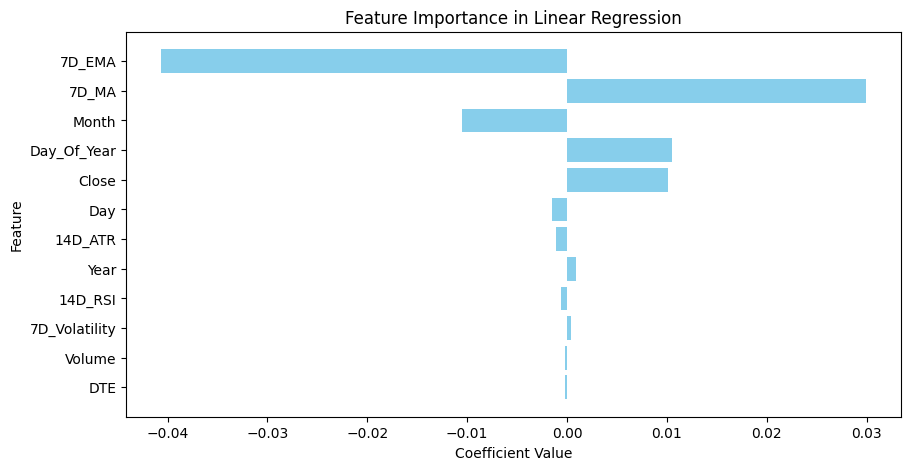

In [7]:
coefficients = model.coef_
coefficients_df = pd.DataFrame({"Feature": feature_cols, "Coefficient": coefficients}).sort_values(by="Coefficient", key=abs, ascending=False)
plt.figure(figsize=(10, 5))
plt.barh(coefficients_df['Feature'], coefficients_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance in Linear Regression')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

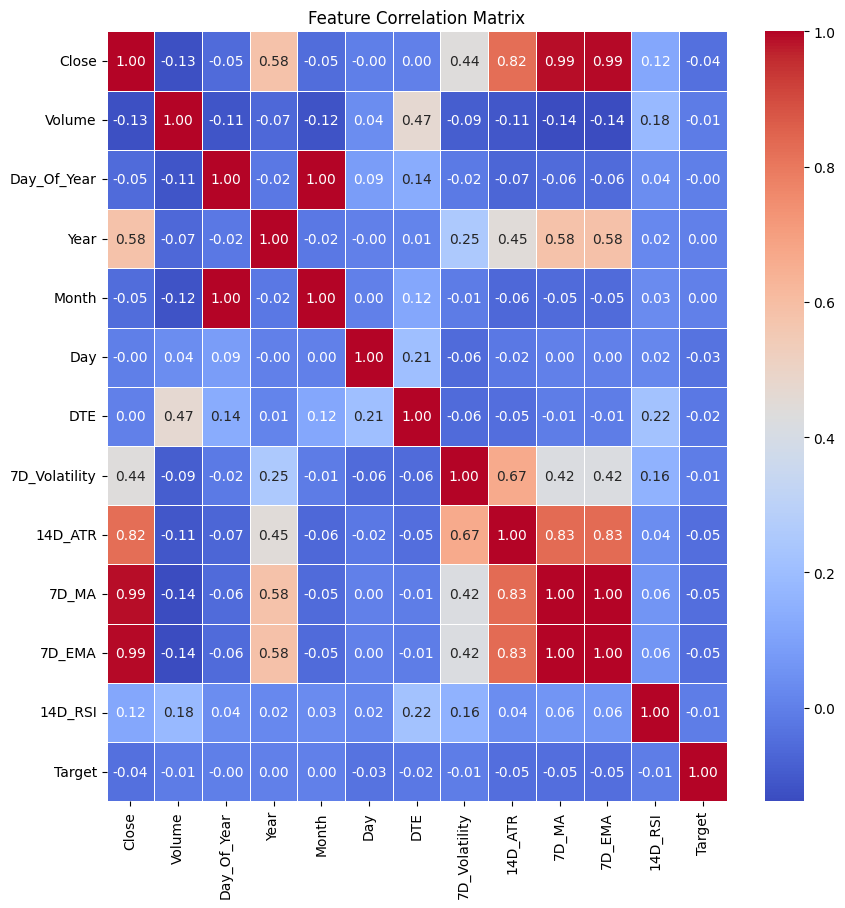

In [8]:
correlation_matrix = X_train_pd.merge(y_train, left_index=True, right_index=True).corr()

plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

# Lasso regression on the market data

Cross-validation R^2 scores on the training set: [-0.00983849 -0.06132372  0.00324065 -0.0683997  -0.01161883]
Average R^2 score: -0.0296
The Lasso Regression R^2 score on the testing set: -0.0060


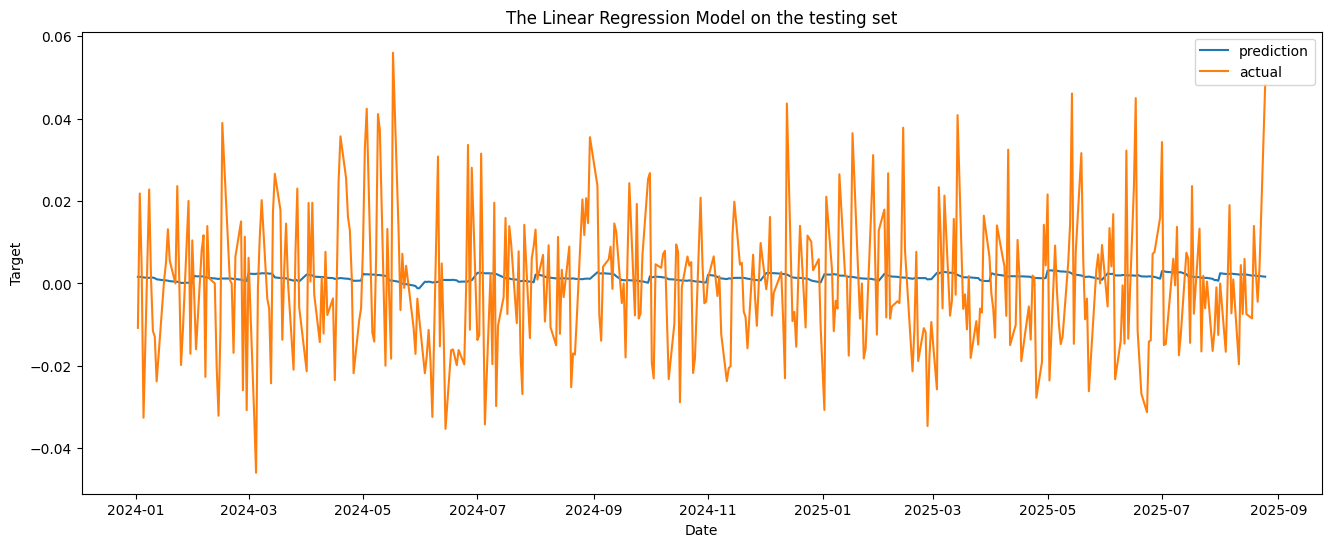

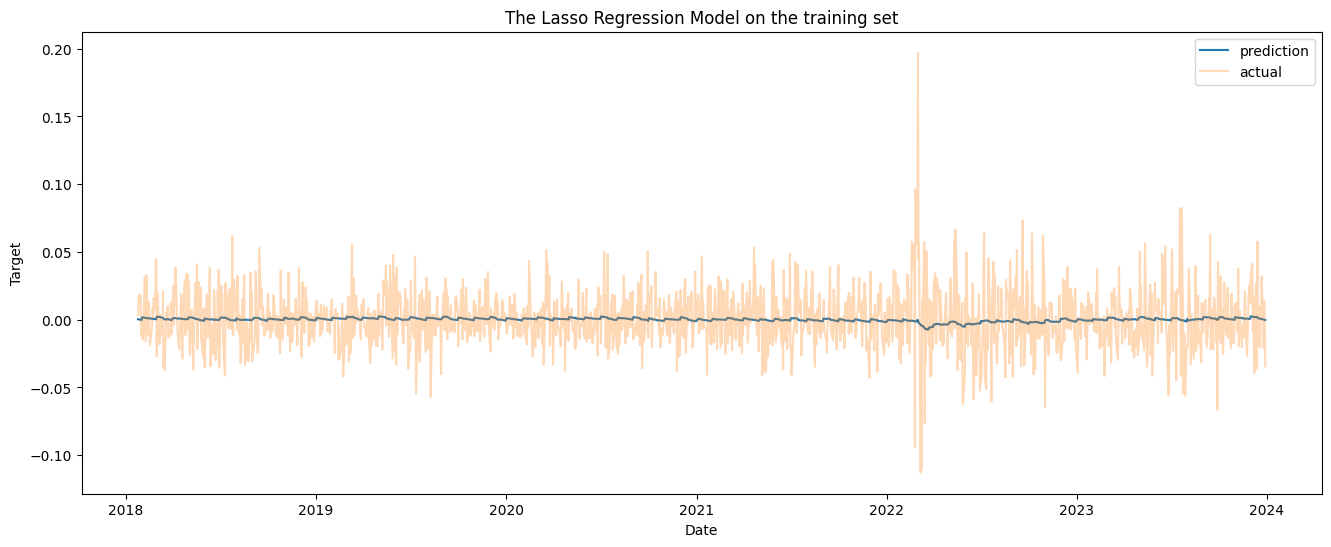

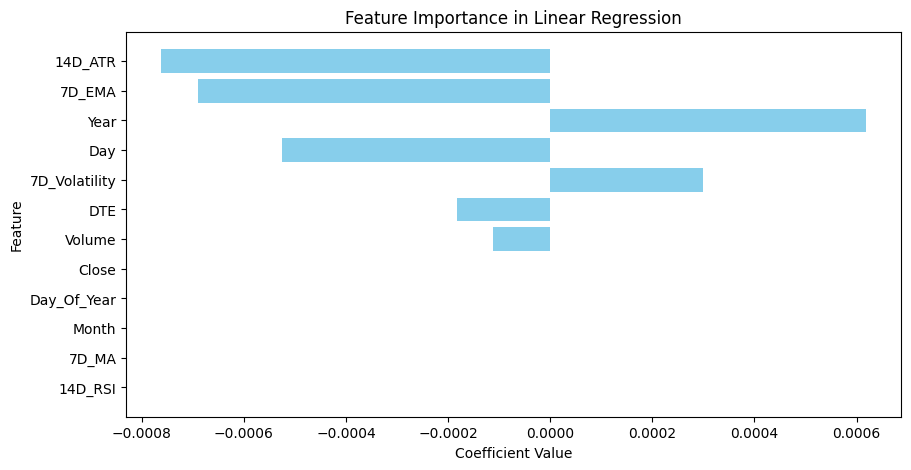

In [9]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha=0.0001)
lasso_model.fit(X_train, y_train)

cv_scores = cross_val_score(lasso_model, X_train, y_train, cv=tscv, scoring='r2')
print(f'Cross-validation R^2 scores on the training set: {cv_scores}')
print(f'Average R^2 score: {np.mean(cv_scores):.4f}')

lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)
print(f"The Lasso Regression R^2 score on the testing set: {r2_score(y_test, y_pred):.4f}")

plt.figure(figsize=(16, 6))
plt.title('The Linear Regression Model on the testing set')
sns.lineplot(x=y_test.index, y=y_pred, label='prediction')
sns.lineplot(x=y_test.index, y=y_test, label='actual')

plt.figure(figsize=(16, 6))
plt.title('The Lasso Regression Model on the training set')
sns.lineplot(x=y_train[1000:].index, y=lasso_model.predict(X_train[1000:]), label='prediction')
sns.lineplot(x=y_train[1000:].index, y=y_train[1000:], label='actual', alpha = 0.3)

coefficients = lasso_model.coef_
coefficients_df = pd.DataFrame({"Feature": feature_cols, "Coefficient": coefficients}).sort_values(by="Coefficient", key=abs, ascending=False)
plt.figure(figsize=(10, 5))
plt.barh(coefficients_df['Feature'], coefficients_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance in Linear Regression')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

## Linear regression model on the training set without 2022 data

Cross-validation R^2 scores on the training set: [-0.09005457 -0.22628891 -0.06715745 -0.04044354 -0.00430495]
Average R^2 score: -0.0856
The R^2 score on the testing set: -0.0010


<Axes: title={'center': 'The Linear Regression Model on the training set'}, xlabel='Date', ylabel='Target'>

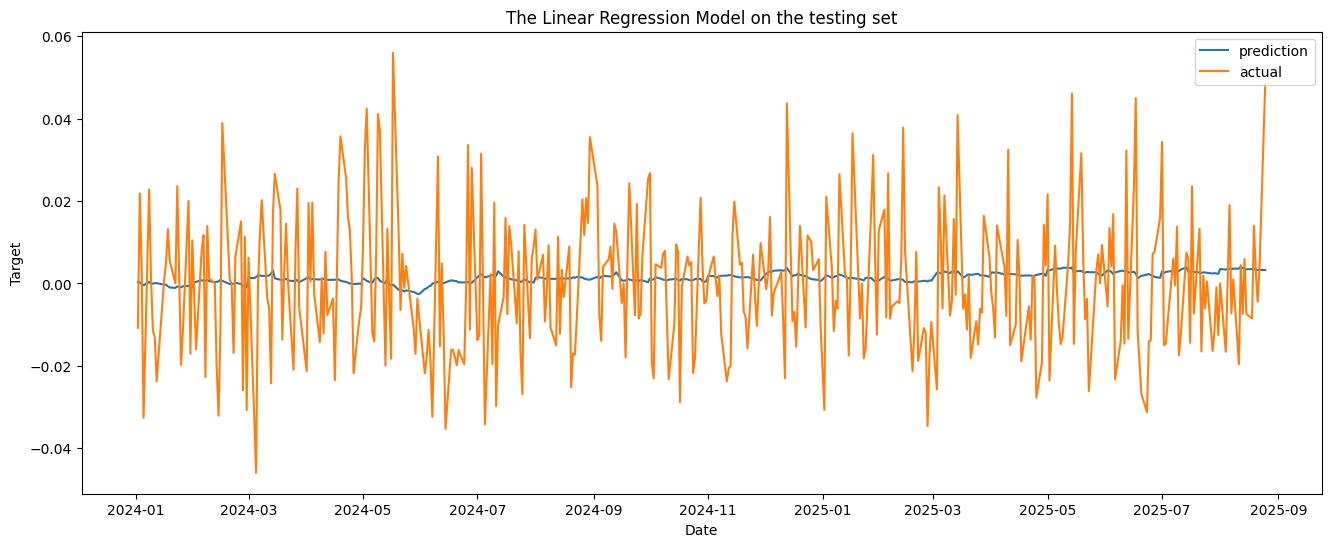

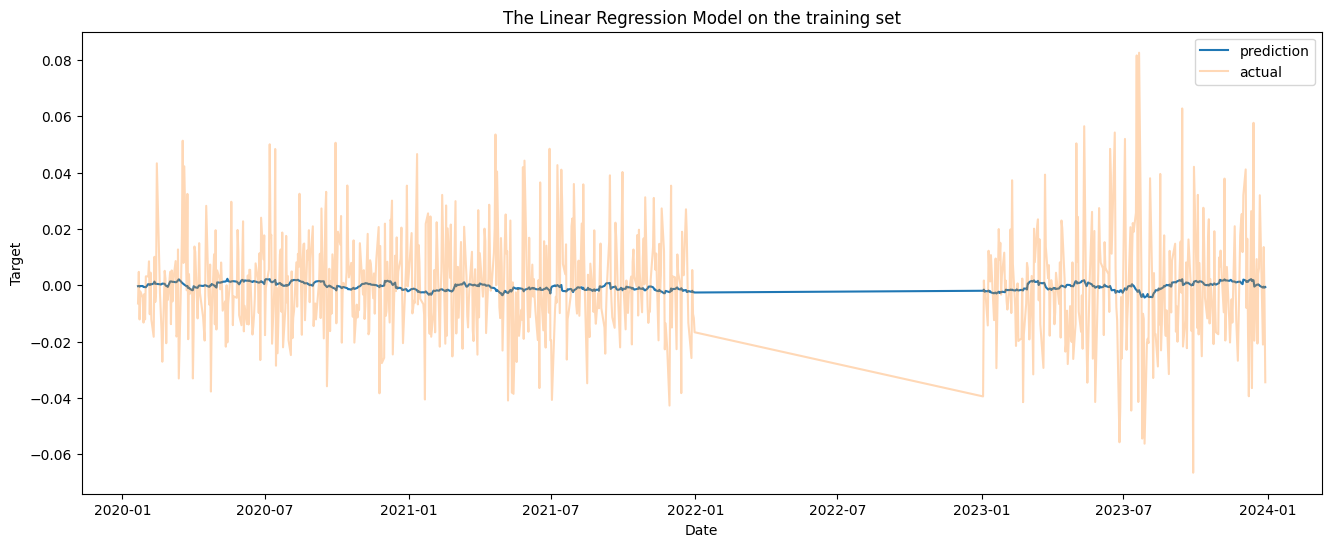

In [10]:
X_train_new = X_train_pd[X_train_pd.index.year != 2022]
y_train_new = y_train[X_train_pd.index.year != 2022]

X_train_new = scaler.fit_transform(X_train_new)
X_test = scaler.transform(X_test_pd)

tscv = TimeSeriesSplit(n_splits=5)
model = LinearRegression()

cv_scores = cross_val_score(model, X_train_new, y_train_new, cv=tscv, scoring='r2')
print(f'Cross-validation R^2 scores on the training set: {cv_scores}')
print(f'Average R^2 score: {np.mean(cv_scores):.4f}')

model.fit(X_train_new, y_train_new)
y_pred = model.predict(X_test)
print(f"The R^2 score on the testing set: {r2_score(y_test, y_pred):.4f}")

plt.figure(figsize=(16, 6))
plt.title('The Linear Regression Model on the testing set')
sns.lineplot(x=y_test.index, y=y_pred, label='prediction')
sns.lineplot(x=y_test.index, y=y_test, label='actual')

plt.figure(figsize=(16, 6))
plt.title('The Linear Regression Model on the training set')
sns.lineplot(x=y_train_new[1500:].index, y=model.predict(X_train_new[1500:]), label='prediction')
sns.lineplot(x=y_train_new[1500:].index, y=y_train_new[1500:], label='actual', alpha = 0.3)


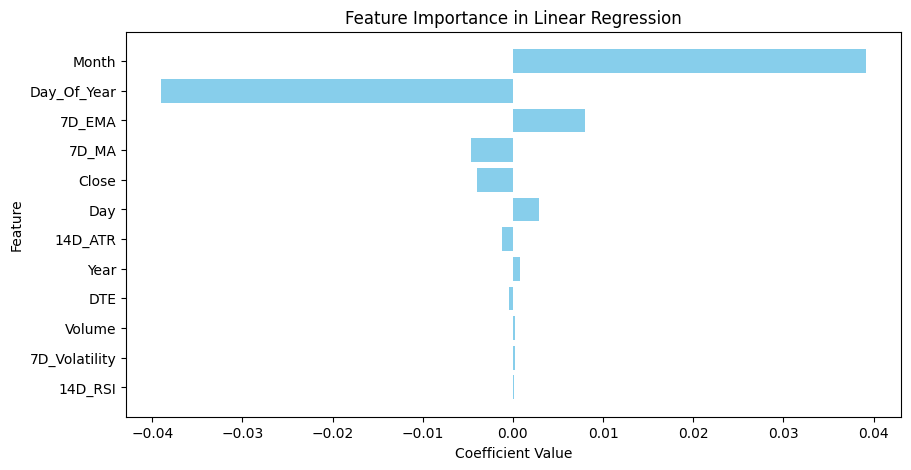

In [11]:
coefficients = model.coef_
coefficients_df = pd.DataFrame({"Feature": feature_cols, "Coefficient": coefficients}).sort_values(by="Coefficient", key=abs, ascending=False)
plt.figure(figsize=(10, 5))
plt.barh(coefficients_df['Feature'], coefficients_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance in Linear Regression')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

# XGB Model with CV

In [12]:
tscv = TimeSeriesSplit(n_splits=10)
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    eval_metric=r2_score,
#    device='cuda',
    reg_alpha=0.1,
    reg_lambda=0.1,
#    gamma=0.1,
#    early_stopping_rounds=250,
#    min_child_weight=5,
#    subsample=0.7,
#    colsample_bytree=0.7,
)

cv_scores = cross_val_score(xgb_model, X_train_new, y_train_new, cv=tscv, scoring='r2')
print(f'Cross-validation R2 scores: {cv_scores}')  # Convert to positive MAE values
print(f'Average R2: {np.mean(cv_scores):.4f}')

Cross-validation R2 scores: [-0.03959771 -0.09634001 -0.02188613 -0.02723121 -0.07757742 -0.06536962
 -0.14055665 -0.09941319 -0.04910256 -0.00743876]
Average R2: -0.0625


[0]	validation_0-rmse:0.01815	validation_0-r2_score:0.00057	validation_1-rmse:0.01659	validation_1-r2_score:-0.00019
[50]	validation_0-rmse:0.01795	validation_0-r2_score:0.02249	validation_1-rmse:0.01653	validation_1-r2_score:0.00618
[100]	validation_0-rmse:0.01780	validation_0-r2_score:0.03828	validation_1-rmse:0.01652	validation_1-r2_score:0.00831
[150]	validation_0-rmse:0.01767	validation_0-r2_score:0.05240	validation_1-rmse:0.01650	validation_1-r2_score:0.01010
[200]	validation_0-rmse:0.01756	validation_0-r2_score:0.06424	validation_1-rmse:0.01649	validation_1-r2_score:0.01148
[250]	validation_0-rmse:0.01747	validation_0-r2_score:0.07444	validation_1-rmse:0.01649	validation_1-r2_score:0.01176
[300]	validation_0-rmse:0.01738	validation_0-r2_score:0.08380	validation_1-rmse:0.01648	validation_1-r2_score:0.01308
[350]	validation_0-rmse:0.01730	validation_0-r2_score:0.09242	validation_1-rmse:0.01648	validation_1-r2_score:0.01303
[400]	validation_0-rmse:0.01722	validation_0-r2_score:0.10

<Axes: title={'center': 'The XGBoost Model on the training set'}, xlabel='Date', ylabel='Target'>

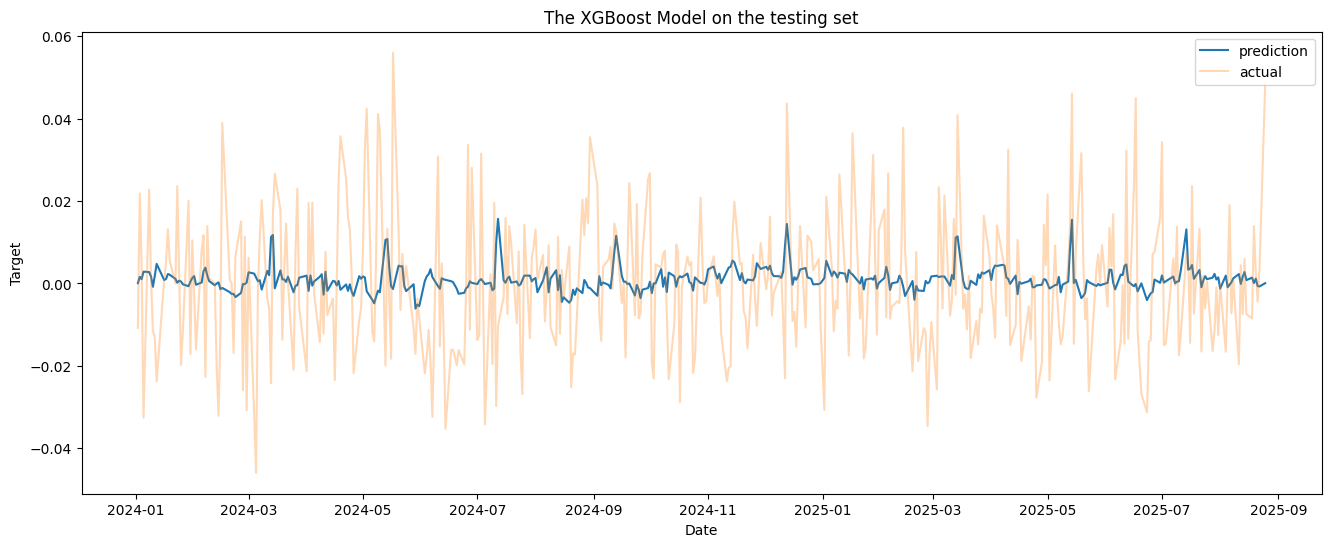

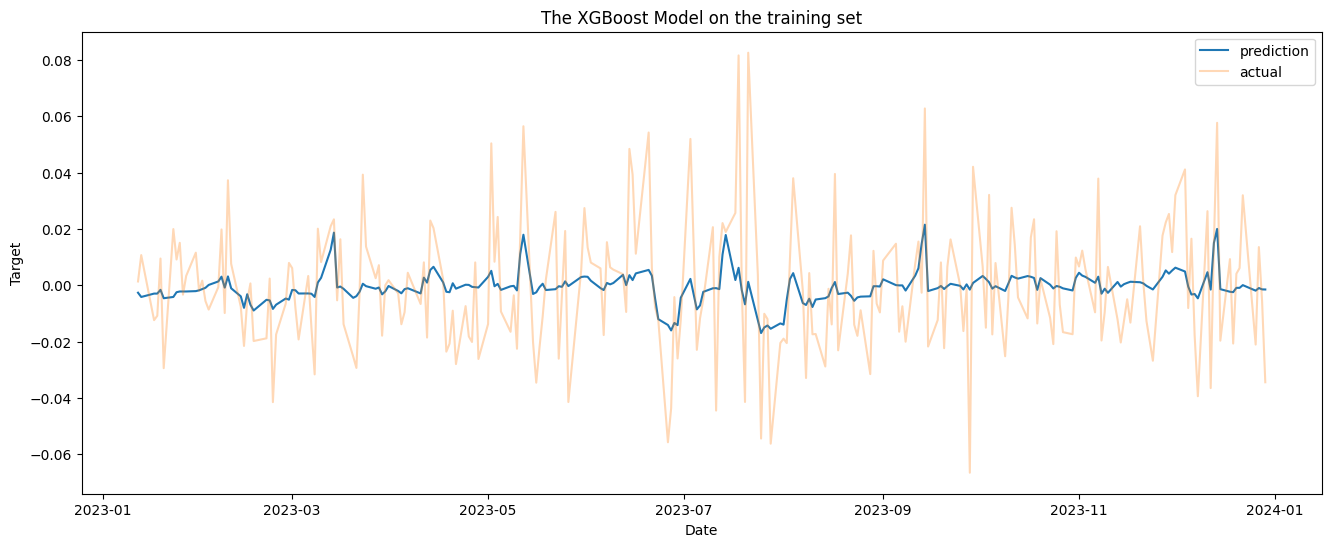

In [13]:
xgb_model.fit(X_train_new, y_train_new, verbose=50,eval_set=[(X_train_new, y_train_new), (X_test, y_test)])
y_pred = xgb_model.predict(X_test)

plt.figure(figsize=(16, 6))
plt.title('The XGBoost Model on the testing set')
sns.lineplot(x=y_test.index, y=y_pred, label='prediction')
sns.lineplot(x=y_test.index, y=y_test, label='actual', alpha = 0.3)

plt.figure(figsize=(16, 6))
plt.title('The XGBoost Model on the training set')
sns.lineplot(x=y_train_new[2000:].index, y=xgb_model.predict(X_train_new[2000:]), label='prediction')
sns.lineplot(x=y_train_new[2000:].index, y=y_train_new[2000:], label='actual', alpha = 0.3)



In [14]:
((y_pred * y_test) >0).sum()/len(y_pred)

np.float64(0.4782608695652174)

# NN Model

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

In [16]:
# Converting the training set and testing set to the torch tensors
X_train, y_train = torch.tensor(X_train_new, dtype=torch.float32), torch.tensor(y_train_new, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader class
BATCH_SIZE = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

/var/folders/2h/69hg_xrd4fb4nytgmwvn8ch40000gn/T/ipykernel_41511/2217384834.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_train, y_train = torch.tensor(X_train_new, dtype=torch.float32), torch.tensor(y_train_new, dtype=torch.float32)
/var/folders/2h/69hg_xrd4fb4nytgmwvn8ch40000gn/T/ipykernel_41511/2217384834.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)


In [17]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(12, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        output = self.linear_relu_stack(x)
        return output

model = NeuralNetwork().to(device)
print(model)

Using mps device
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [18]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
#    test_loss /= num_batches
    print(f"Test loss: \n: {test_loss:>0.8f} \n")

In [19]:
epochs = 500
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


/Users/thwang/PycharmProjects/ErdosAgriDerivPredict/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.004059  [   32/ 2243]
loss: 0.003162  [  352/ 2243]
loss: 0.004709  [  672/ 2243]
loss: 0.003263  [  992/ 2243]
loss: 0.003584  [ 1312/ 2243]
loss: 0.003860  [ 1632/ 2243]
loss: 0.003131  [ 1952/ 2243]


/Users/thwang/PycharmProjects/ErdosAgriDerivPredict/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.001472  [  213/ 2243]


/Users/thwang/PycharmProjects/ErdosAgriDerivPredict/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test loss: 
: 0.03021949 

Epoch 2
-------------------------------
loss: 0.002697  [   32/ 2243]
loss: 0.002717  [  352/ 2243]
loss: 0.003038  [  672/ 2243]
loss: 0.002720  [  992/ 2243]
loss: 0.004565  [ 1312/ 2243]
loss: 0.002645  [ 1632/ 2243]
loss: 0.004139  [ 1952/ 2243]
loss: 0.004922  [  213/ 2243]
Test loss: 
: 0.02910845 

Epoch 3
-------------------------------
loss: 0.002033  [   32/ 2243]
loss: 0.004576  [  352/ 2243]
loss: 0.002702  [  672/ 2243]
loss: 0.002147  [  992/ 2243]
loss: 0.004015  [ 1312/ 2243]
loss: 0.002587  [ 1632/ 2243]
loss: 0.001993  [ 1952/ 2243]
loss: 0.007045  [  213/ 2243]
Test loss: 
: 0.02827483 

Epoch 4
-------------------------------
loss: 0.002927  [   32/ 2243]
loss: 0.002832  [  352/ 2243]
loss: 0.002941  [  672/ 2243]
loss: 0.002684  [  992/ 2243]
loss: 0.003432  [ 1312/ 2243]
loss: 0.001900  [ 1632/ 2243]
loss: 0.002570  [ 1952/ 2243]
loss: 0.001543  [  213/ 2243]
Test loss: 
: 0.02737306 

Epoch 5
-------------------------------
loss: 0.0028

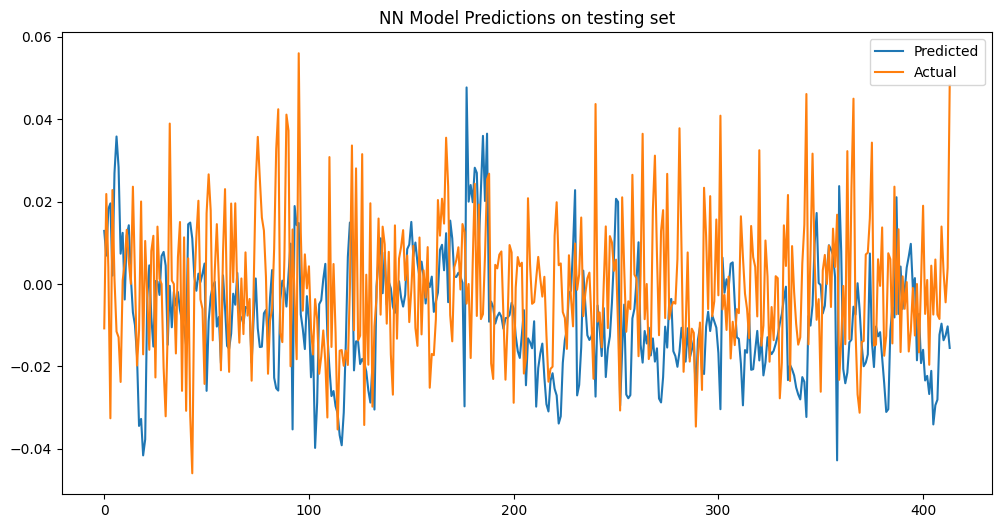

-1.0259194374084473


In [20]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test.to(device)).squeeze().cpu().numpy()

y_pred_test_rescaled = y_pred_test.reshape(-1, 1)
y_test_rescaled = y_test.numpy().reshape(-1, 1)

# Plot results

plt.figure(figsize=(12, 6))
plt.plot(y_pred_test_rescaled, label='Predicted')
plt.plot(y_test_rescaled, label='Actual')
plt.legend()
plt.title("NN Model Predictions on testing set")
plt.show()

print(r2_score(y_test_rescaled, y_pred_test_rescaled))

In [21]:
((y_test_rescaled * y_pred_test_rescaled) >0).sum()/len(y_test_rescaled)

np.float64(0.4806763285024155)

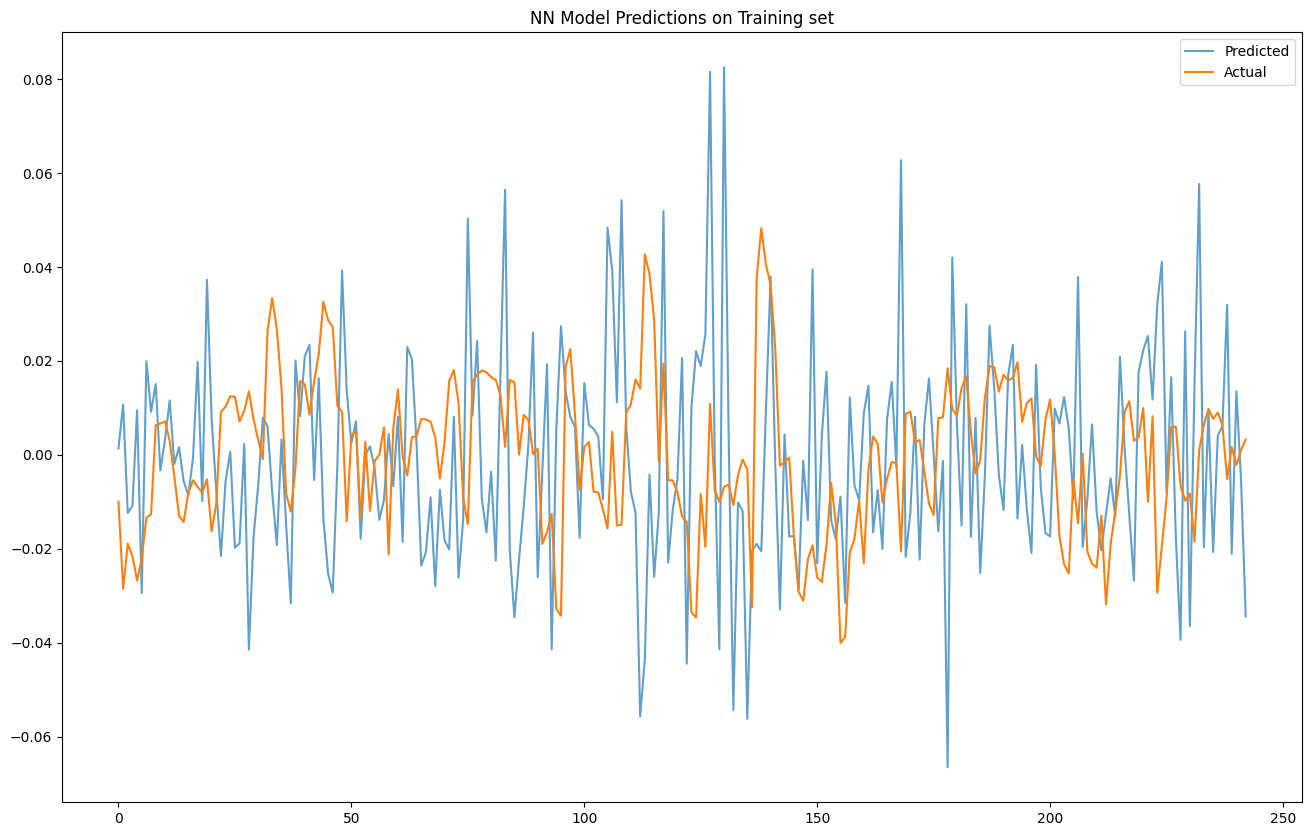

-0.6598402261734009


In [22]:
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train.to(device)).squeeze().cpu().numpy()

y_pred_train_rescaled = y_pred_train.reshape(-1, 1)
y_train_rescaled = y_train.numpy().reshape(-1, 1)

# Plot results

plt.figure(figsize=(16, 10))
plt.plot(y_train_rescaled[2000:], label='Predicted', alpha=0.7)
plt.plot(y_pred_train_rescaled[2000:], label='Actual')
plt.legend()
plt.title("NN Model Predictions on Training set")
plt.show()

print(r2_score(y_train_rescaled , y_pred_train_rescaled))

# LSTM Model

In [23]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler


In [ ]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length][-1])
    return np.array(sequences), np.array(targets)

data = SRW_data[feature_cols + ['Target']]

scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data)

SEQ_LENGTH = 60
X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Convert to PyTorch tensors
X_train, y_train = torch.tensor(X[:-500], dtype=torch.float32), torch.tensor(y[:-500], dtype=torch.float32)
X_test, y_test = torch.tensor(X[-500:], dtype=torch.float32), torch.tensor(y[-500:], dtype=torch.float32)

# Reshape for LSTM (batch_size, seq_length, num_features)
X_train = X_train.view(-1, SEQ_LENGTH, 13)
X_test = X_test.view(-1, SEQ_LENGTH, 13)

# Create DataLoader
BATCH_SIZE = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim=13, hidden_dim=64, num_layers=2, output_dim=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Take last output from LSTM
        return out

# Initialize Model
model = LSTMModel()


In [ ]:
# Define Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
EPOCHS = 1000
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        y_pred = model(batch_x)
        loss = criterion(y_pred.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss/len(train_loader):.6f}')

In [ ]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test).squeeze().cpu().numpy()

# Inverse transform predictions
# y_pred_test_rescaled = scaler.inverse_transform(y_pred_test.reshape(-1, 1))
# y_test_rescaled = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

y_pred_test_rescaled = y_pred_test.reshape(-1, 1)
y_test_rescaled = y_test.numpy().reshape(-1, 1)

# Plot results

plt.figure(figsize=(12, 6))
plt.plot(data.index[-500:], y_test_rescaled, label='Actual')
plt.plot(data.index[-500:], y_pred_test_rescaled, label='Predicted')
plt.legend()
plt.title("LSTM Model Predictions on testing set")
plt.show()

print(f"r2 score {r2_score(y_test_rescaled, y_pred_test_rescaled):.4f}")

In [ ]:
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train).squeeze().cpu().numpy()

# Inverse transform predictions
# y_pred_test_rescaled = scaler.inverse_transform(y_pred_test.reshape(-1, 1))
# y_test_rescaled = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

y_pred_train_rescaled = y_pred_train.reshape(-1, 1)
y_train_rescaled = y_train.numpy().reshape(-1, 1)

# Plot results

plt.figure(figsize=(12, 6))
plt.plot(data.index[60:-500], y_train_rescaled, label='Actual')
plt.plot(data.index[60:-500], y_pred_train_rescaled, label='Predicted')
plt.legend()
plt.title("LSTM Model Predictions on training set")
plt.show()

print(f"r2 score {r2_score(y_train_rescaled, y_pred_train_rescaled):.4f}")